# Using the TranslationProblem on PCA ST data and UNI encoded histology
https://moscot.readthedocs.io/en/latest/notebooks/tutorials/600_tutorial_translation.html

In [1]:
import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.cross_modality import TranslationProblem

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc

# My own packages
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from plotnine import *
import seaborn as sns
import os
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["JAX_PLATFORMS"]="cpu"
import jax
jax.devices()

[CpuDevice(id=0)]

We will use the average FOSCTTM (fraction of samples closer to the true match) measure implemented below for evaluation (metric used in [Demetci et al., 2022]). This metric measures the alignment between two domains by computing the average fraction of samples that are closer to their true match than a fixed sample, where a perfect alignment results in a FOSCTTM value of zero.

In [3]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

## Data loading

### Load (and converse to ) Anndata

In [3]:
st_path = "/p/project1/hai_fzj_bda/berr1/Data/transcriptomics_zhuang_1_pca.csv" 
histo_path = "/p/project1/hai_fzj_bda/koenig8/histo/embeddings_768/uni_embeddings.h5ad"

adata_histo = ad.io.read_h5ad(histo_path)
df_st = pd.read_csv(st_path).drop(columns = "Unnamed: 0")
adata_histo

AnnData object with n_obs × n_vars = 190659 × 1536
    obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice'

In [4]:
len(df_st['brain_section_label'].unique())

129

In [3]:
adata_st = ad.AnnData(X = np.array(df_st.iloc[:, 1:51]), obs = df_st.iloc[:, [0, 51,52,53,54,55,56]])
adata_st

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 50000 × 50
    obs: 'patch_id', 'patch_parcellation_nicheformer', 'patch_size', 'x_ccf', 'y_ccf', 'z_ccf', 'brain_section_label'

In [4]:
# Rename columns with the same information
adata_st.obs = adata_st.obs.rename(columns={
    "patch_parcellation_nicheformer": "brain_area",
    "x_ccf": "x_st",
    "y_ccf": "y_st",
    "z_ccf": "z_st",
    "patch_size": "patchsize"
})

In [5]:
adata_st.obs.sample(4)

,patch_id,brain_area,patchsize,x_st,y_st,z_st,brain_section_label
31255,31256,Isocortex,60,4.917677,4.132252,1.305087,Zhuang-ABCA-1.057
8324,8325,HIP,86,8.149073,4.234614,1.799959,Zhuang-ABCA-1.091
27492,27493,Isocortex,40,6.072522,1.231644,5.399747,Zhuang-ABCA-1.072
27127,27128,white_matter,58,7.290514,1.367347,4.103875,Zhuang-ABCA-1.085


In [6]:
adata_histo.obs.sample(4)

,image_id,patchsize,center_ccf,pixel_coord,distance,nearest_ST,nearest_cell_id,target_atlas_plate,distance_new,x,y,z,x_st,y_st,z_st,image_nr,brain_area,group,slice
156939,100960033_1879,256,"{'x': 9041.11758177639, 'y': 5748.495548096338...","{'center_x': 7950, 'center_y': 5850, 'x_min': ...",[40.92738478],"{'x': 9.002275377199592, 'y': 5.74280397283207...",1019171910102410062,83.0,40.927385,9041.117582,5748.495548,8506.087894,9.002275,5.742804,8.517661,100960033,RHP,11,100960033
52317,100960092_30,256,"{'x': 7538.782270160229, 'y': 681.609905292008...","{'center_x': 4350, 'center_y': 900, 'x_min': 4...",[42.81733617],"{'x': 7.58083378874254, 'y': 0.673823631366438...",1019171907100990109,65.0,42.817336,7538.782270,681.609905,4235.678776,7.580834,0.673824,4.237769,100960092,Isocortex,16,100960092
174657,100960316_1642,256,"{'x': 5095.787417538992, 'y': 5837.05850906867...","{'center_x': 5400, 'center_y': 5550, 'x_min': ...",[25.03506918],"{'x': 5.120705821041354, 'y': 5.83669199097081...",1018093344101680041-1,45.0,25.035069,5095.787418,5837.058509,6127.278072,5.120706,5.836692,6.124892,100960316,HY,11,100960316
352,100960088_352,256,"{'x': 7622.583940491826, 'y': 1687.87804746625...","{'center_x': 7950, 'center_y': 1950, 'x_min': ...",[30.30333386],"{'x': 7.593465131835028, 'y': 1.67995510064524...",1019171907102360252,65.0,30.303334,7622.583940,1687.878047,8148.714519,7.593465,1.679955,8.145955,100960088,HIP,17,100960088


### Check if labels in obs match

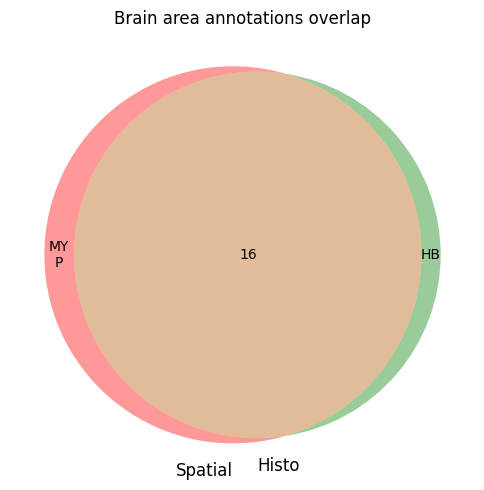

In [7]:
# brain_area
set1 = set(list(adata_st.obs["brain_area"]))
set2 = set(list(adata_histo.obs["brain_area"]))

# Compute unique and shared elements
only_in_set1 = set1 - set2  # Unique to Set 1
only_in_set2 = set2 - set1  # Unique to Set 2
shared = set1 & set2        # Shared elements

# Create Venn diagram
plt.figure(figsize=(6, 6))
venn = venn2([set1, set2], set_labels=("Spatial", "Histo"))

# Add title
plt.title("Brain area annotations overlap")

# Annotate unique elements in Set 1
if only_in_set1:
    text1 = "\n".join(only_in_set1)
    venn.get_label_by_id("10").set_text(text1)

# Annotate unique elements in Set 2
if only_in_set2:
    text2 = "\n".join(only_in_set2)
    venn.get_label_by_id("01").set_text(text2)

plt.show()

In [8]:
# Color map for future plots
cats = list(set1 | set2)
# Use a color map with more distinct colors
cmap = plt.get_cmap("tab20")  # Try 'tab20', 'viridis', or 'rainbow'

# Generate unique colors
color_map = {cat: cmap(i / len(cats)) for i, cat in enumerate(cats)}

# Print the color map
print(color_map)

{'STRv': (np.float64(0.12156862745098039), np.float64(0.4666666666666667), np.float64(0.7058823529411765), np.float64(1.0)), 'MB': (np.float64(0.6823529411764706), np.float64(0.7803921568627451), np.float64(0.9098039215686274), np.float64(1.0)), 'CB': (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)), 'sAMY': (np.float64(1.0), np.float64(0.7333333333333333), np.float64(0.47058823529411764), np.float64(1.0)), 'STRd': (np.float64(0.17254901960784313), np.float64(0.6274509803921569), np.float64(0.17254901960784313), np.float64(1.0)), 'HB': (np.float64(0.596078431372549), np.float64(0.8745098039215686), np.float64(0.5411764705882353), np.float64(1.0)), 'HIP': (np.float64(0.8392156862745098), np.float64(0.15294117647058825), np.float64(0.1568627450980392), np.float64(1.0)), 'TH': (np.float64(1.0), np.float64(0.596078431372549), np.float64(0.5882352941176471), np.float64(1.0)), 'P': (np.float64(0.5803921568627451), np.float64(0.4039215686274

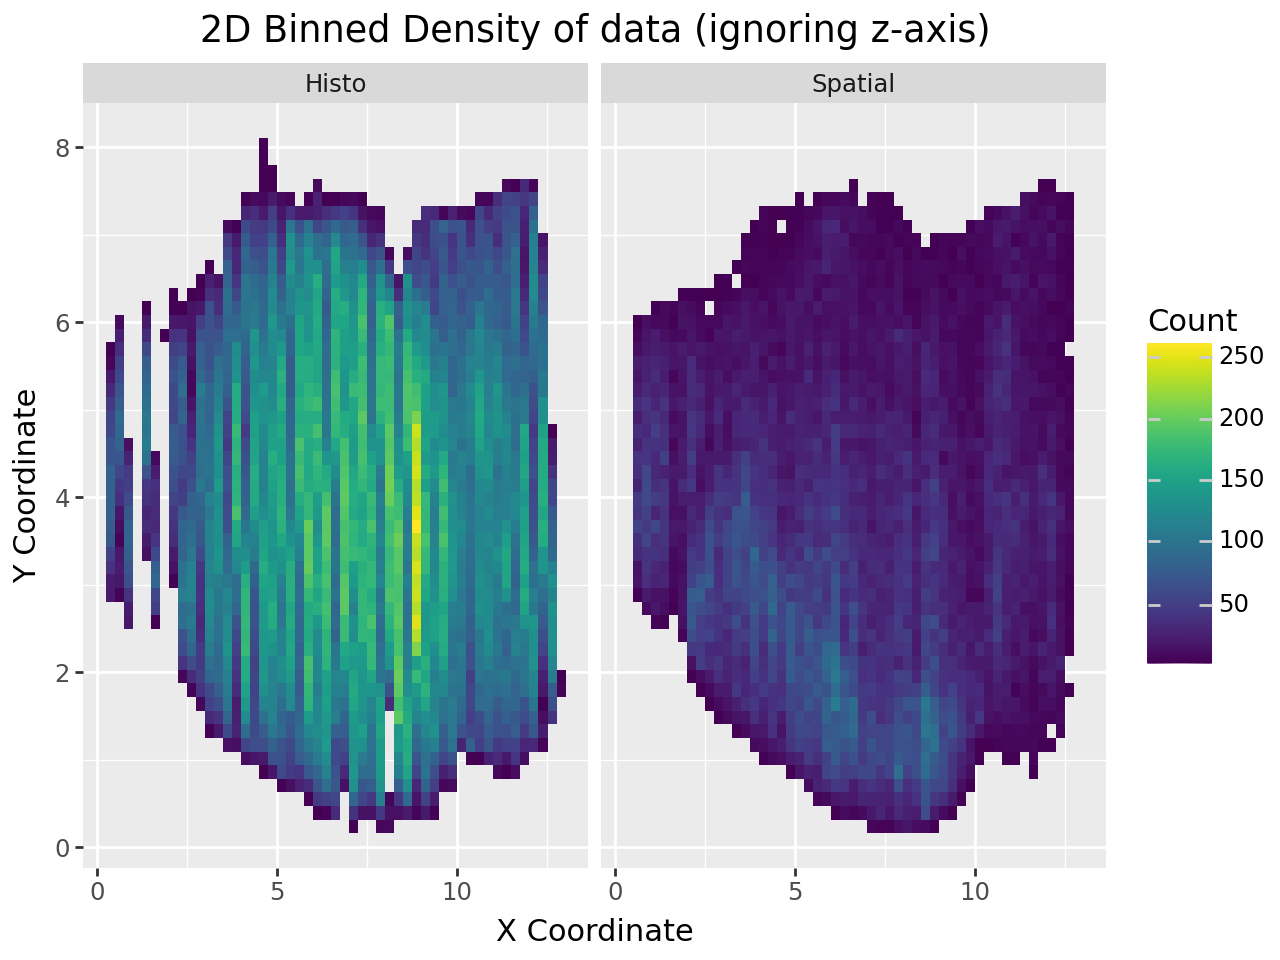

In [10]:
np.random.seed(42)
N = 190659
df1 = adata_histo.obs.loc[:, ("x_st", "y_st")].rename(columns=lambda col: col.split("_")[0])
df1["Dataset"] = "Histo"
df2 = adata_st.obs.loc[:, ("x_st", "y_st")].rename(columns=lambda col: col.split("_")[0])
df2["Dataset"] = "Spatial"

# Create a DataFrame
df = pd.concat([df1, df2])

plot = (
    ggplot(df, aes(x="x", y="y")) +
    stat_bin2d(bins=50) +  # Adjust bins for resolution
    scale_fill_cmap() +  # Use a perceptually uniform color scale
    facet_wrap("~Dataset") +
    labs(title="2D Binned Density of data (ignoring z-axis)",
         x="X Coordinate",
         y="Y Coordinate",
         fill="Count")  # Color represents density
)

# Show plot
plot

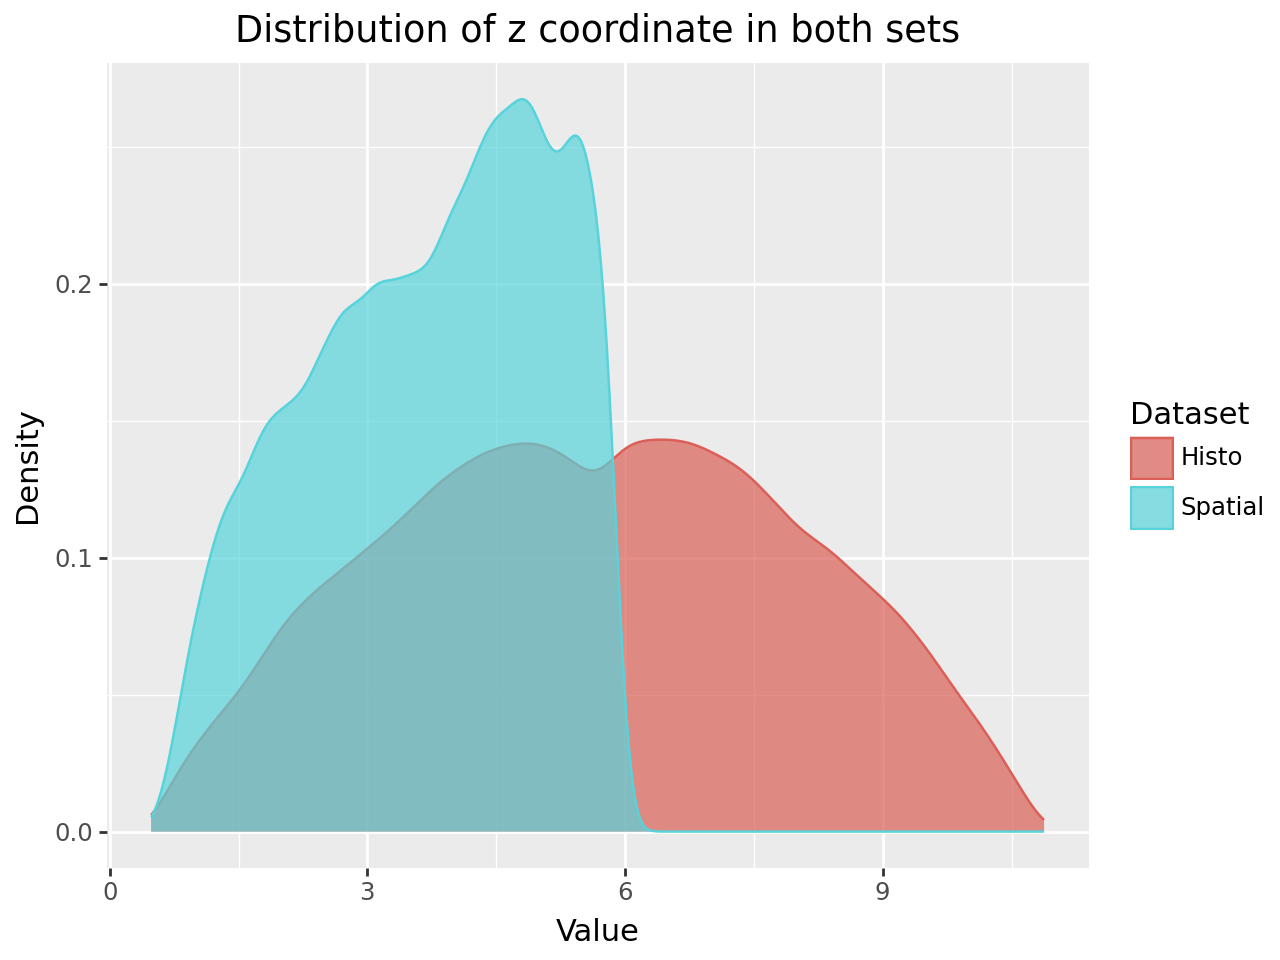

In [12]:
# Convert to a DataFrame with labels
data1 = adata_histo.obs["z_st"].to_numpy()
data2 = adata_st.obs["z_st"].to_numpy()
df = pd.DataFrame({
    "Value": np.concatenate([data1, data2]),
    "Dataset": ["Histo"] * len(data1) + ["Spatial"] * len(data2)  # Labels for grouping
})

# Create density plot
plot = (
    ggplot(df, aes(x="Value", color="Dataset", fill="Dataset")) +
    geom_density(alpha=0.7) +  # Alpha makes overlapping regions visible
    labs(title="Distribution of z coordinate in both sets",
         x="Value",
         y="Density")
)

# Show plot
plot

The data annotations are very similar, most of the brain areas are present in both of the modalities. Spatially, we can see that both methods cover the same range of x and y, even though histo is more dense. From the z axis plot it seems that for spatial transcriptomics, only regions from the front of the brain were made, or alternatively that the brain used for st was smaller in the z axis. It might also be an artifact of the registration process. 
### The z coordinate is "left-to-right", only left hemisphere was used

### Subset both for first attempt
For a first test run, i will only use one slide from both modalities (picked by z-axis) and also equate the sample size

In [13]:
ad_histo = adata_histo[np.abs(adata_histo.obs.z_st - 4.5) <= 0.2]
ad_st = adata_st[np.abs(adata_st.obs.z_st - 4.5) <= 0.2]
ad_histo.shape, ad_st.shape

((10704, 1536), (5191, 50))

In [14]:
# First reduce ad_histo by removing z-values greate 6
# ad_histo = ad_histo[ad_histo.obs.z_st  < 6]
# ad_histo.shape

In [15]:
# Now randomly sample to keep n_samples equal (later try with different)
ad_histo = ad_histo[np.random.choice(ad_histo.n_obs, ad_st.n_obs, replace=False)]
ad_histo.shape, ad_st.shape

((5191, 1536), (5191, 50))

==> They have the same number of obs, but differing var

## Preprocessing
We perform a L2-normalization of the ATAC data using sklearn.preprocessing.normalize to scale the samples to have unit norm. This is useful, since we quantify the similarity of pair of samples

In [8]:
#adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
#    adata_atac.obsm["ATAC_lsi_red"], norm="l2"
#)

## Visualization
Let’s take a look at the ATAC and RNA data by plotting a UMAP of the respective domain before the alignment, colored according to cell type.

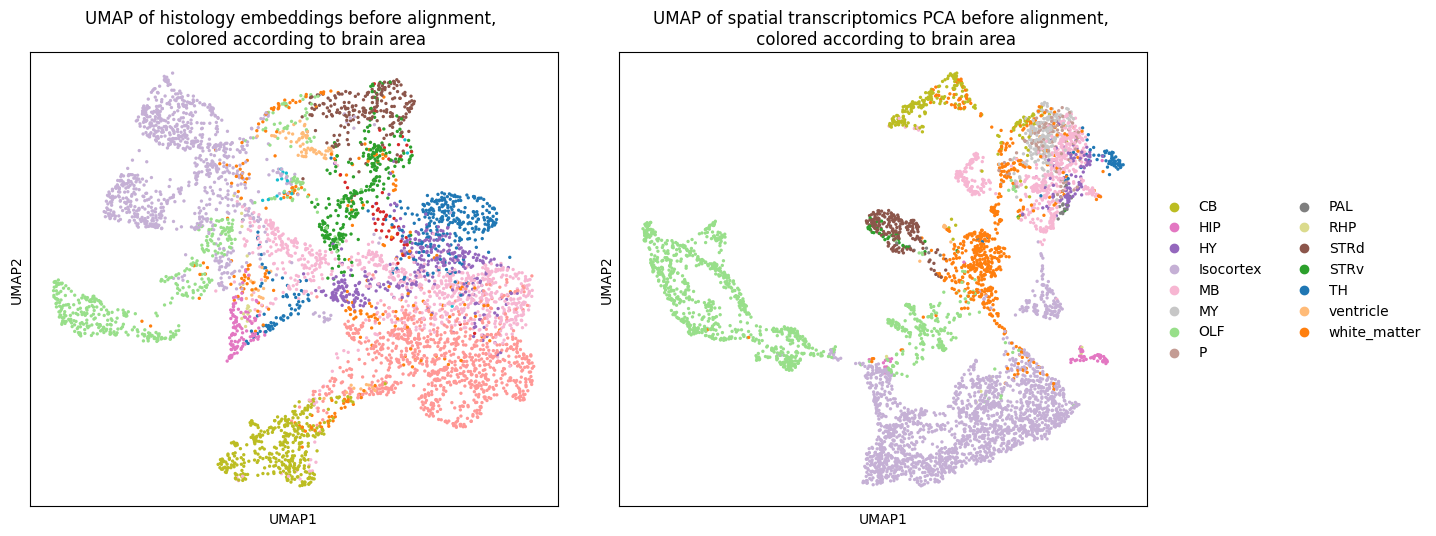

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pp.neighbors(ad_histo, n_neighbors=20, random_state=42)
sc.tl.umap(ad_histo)
sc.pl.umap(ad_histo, color="brain_area", ax=ax1, show=False, palette = color_map)
ax1.legend().remove()
ax1.set_title(
    "UMAP of histology embeddings before alignment, \n colored according to brain area"
)

sc.pp.neighbors(ad_st, n_neighbors=20, random_state=42)
sc.tl.umap(ad_st)
sc.pl.umap(ad_st, color="brain_area", ax=ax2, show=False, palette = color_map)
ax2.set_title(
    "UMAP of spatial transcriptomics PCA before alignment, \n colored according to brain area"
)
plt.tight_layout(pad=3.0)
plt.show()

## Prepare the TranslationProblem
We need to initialize the TranslationProblem by passing the source and target AnnData objects. After initialization, we need to prepare() the problem. In this particular case, we need to pay attention to 3 parameters:

 - src_attr: specifies the attribute in AnnData that contains the source distribution. In our case it refers to the key in obsm that stores the ATAC LSI embedding.

 - tgt_attr: specifies the attribute in AnnData that contains the target distribution. In our case it refers to the key in obsm that stores the RNA PCA embedding.

 - joint_attr[optional]: specifies a joint attribute over a common feature space to incorporate a linear term into the quadratic optimization problem. Initially, we consider the pure Gromov-Wasserstein setting and subsequently explore the fused problem.

## In my case
 - Since i dont have actual data anymore, only the embeddings, i will copy the embeddings into adata.obsm for both. From the description of the problem, it seems to me that the actual data is not used when calculating the TranslationProblem, but if it is used i need to load the original data as well.
 -  I dont know if it makes sense to normalize the PCA results (or later the embeddings from the transformer) for the spatial modality => First try without and then with

In [16]:
adata_histo.obsm["uni_embedding"] = adata_histo.X
adata_st.obsm["pca_embedding"] = adata_st.X

ad_histo.obsm["uni_embedding"] = ad_histo.X
ad_st.obsm["pca_embedding"] = ad_st.X

/tmp/ipykernel_16215/761607121.py:4: ImplicitModificationWarning: Setting element `.obsm['uni_embedding']` of view, initializing view as actual.
/tmp/ipykernel_16215/761607121.py:5: ImplicitModificationWarning: Setting element `.obsm['pca_embedding']` of view, initializing view as actual.


In [30]:
# Save the adatas for quick switching between GPU and CPU
out_path = "/p/project1/hai_fzj_bda/koenig8/ot/data/translation1"
adata_histo.write_h5ad(os.path.join(out_path, "adata_histo.h5ad"))
adata_st.write_h5ad(os.path.join(out_path, "adata_st.h5ad"))

ad_histo.write_h5ad(os.path.join(out_path, "adata_histo_small.h5ad"))
ad_st.write_h5ad(os.path.join(out_path, "adata_st_small.h5ad"))

In [4]:
# Reload if necessary
out_path = "/p/project1/hai_fzj_bda/koenig8/ot/data/translation1"
adata_histo = ad.io.read_h5ad(os.path.join(out_path, "adata_histo.h5ad"))
adata_st = ad.io.read_h5ad(os.path.join(out_path, "adata_st.h5ad"))

ad_histo = ad.io.read_h5ad(os.path.join(out_path, "adata_histo_small.h5ad"))
ad_st = ad.io.read_h5ad(os.path.join(out_path, "adata_st_small.h5ad"))

In [6]:
tp = TranslationProblem(adata_src=ad_st, adata_tgt=ad_histo)
tp = tp.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding")

## Solve the TranslationProblem
In fused quadratic problems, the alpha parameter defines the convex combination between the quadratic and linear terms. By default, alpha = 1, that is, we only consider the quadratic problem, ignoring the joint_attr. We choose a small value for epsilon to obtain a sparse transport map

In [18]:
tp = tp.solve(alpha=1.0, epsilon=1e-3)
tp.save("/p/project1/hai_fzj_bda/koenig8/ot/models/small_translation.pkl", overwrite = True)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5191, 5191)].                                          


## TODO Big translation problem

In [62]:
tp2 = TranslationProblem(adata_src=adata_st, adata_tgt=adata_histo)
tp2 = tp2.prepare(src_attr="pca_embedding", tgt_attr="uni_embedding")

In [75]:
tp2 = tp2.solve(alpha=1.0, epsilon=0, batch_size = 10, rank = 10)
tp2.save("/p/project1/hai_fzj_bda/koenig8/ot/models/big_translation.pkl", overwrite = True)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(50000, 190659)].                                       


2025-03-12 14:39:49.499420: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB (rounded to 1171408896)requested by op 
2025-03-12 14:39:49.499577: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *____*________************************************************************************************__


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1171408896 bytes.

## Translate the TranslationProblem
We can now project one domain onto the other. The boolean parameter forward determines the direction of the barycentric projection. In our case, we project the source distribution AnnData (ATAC) onto the target distribution AnnData (RNA), therefore we use forward = True. The function translate() returns the translated object in the target space (or source space respectively)
```
translated = tp.translate(source="src", target="tgt", forward=True)
```
This is done in cpu_translate.ipynb, for memory reasons. So we only load the result here

In [14]:
out_path = "/p/project1/hai_fzj_bda/koenig8/ot/data/translation1"
translated = np.load(os.path.join(out_path, "translated_small.npy"))
translated.shape

(5191, 1536)

In [22]:
print(
    "Average FOSCTTM score of translating spatial transcriptomics onto Histology: ",
    foscttm(ad_histo.obsm["uni_embedding"], translated),
)

Average FOSCTTM score of translating spatial transcriptomics onto Histology:  0.5001


For the sake of visualization, we concatenate the translated chromatin accessibility points mapped to the gene expression PCA domain to the original gene expression PCA data. Then we plot a UMAP of the concatenated data in the gene expression domain, colored according to the original domain and cell type.

In [15]:
adata = sc.concat(
    [ad_st, ad_histo],
    join="outer",
    label="batch",
    keys=["ST (translated)", "Histo"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, ad_histo.obsm["uni_embedding"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


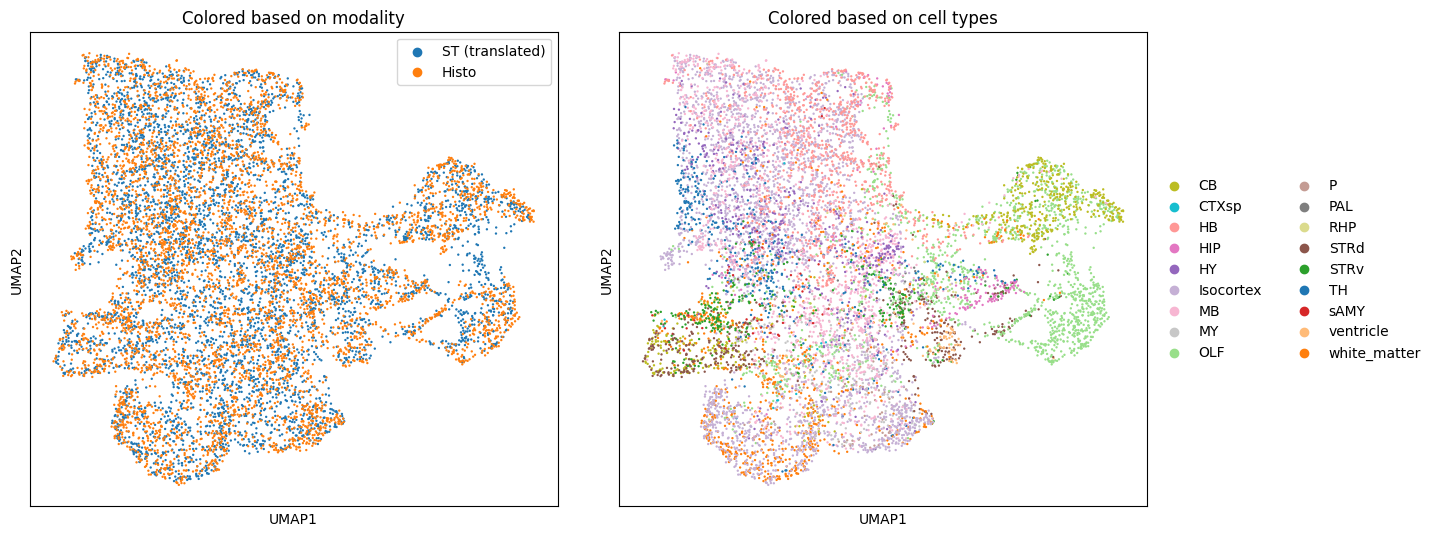

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["brain_area"], ax=ax2, show=False, palette=color_map)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

# Extend the TranslationProblem to the fused setting

We proceed to extend the TranslationProblem to incorporate the fused setting. In this regard, we aim to evaluate the potential benefits of augmenting the quadratic problem with a linear term. For this we could either use the coordinates (very unrealistic to have in a general setting), or the brain area (would need to be more general area like cortex, hippocampus, ..). For now use the brain area we have already

In [29]:
# Store one-hot encoding of brain area

brain_area = pd.concat(
    (adata_st.obs.brain_area, adata_histo.obs.brain_area), axis=0, ignore_index=True
).to_numpy().reshape(-1,1)
n = adata_st.obs.shape[0]

encoder = pp.OneHotEncoder() 
onehot_matrix = encoder.fit_transform(brain_area)

onehot_matrix.shape

(240659, 19)

In [37]:
# Store in adatas
ad_histo.obsm["brain_area_onehot"] = encoder.transform(ad_histo.obs.brain_area.to_numpy().reshape(-1, 1))
ad_st.obsm["brain_area_onehot"] = encoder.transform(ad_st.obs.brain_area.to_numpy().reshape(-1, 1))

adata_st.obsm["brain_area_onehot"] = onehot_matrix[0:n, :]
adata_histo.obsm["brain_area_onehot"] = onehot_matrix[n:, :]

adata_histo.write_h5ad(os.path.join(out_path, "adata_histo.h5ad"))
adata_st.write_h5ad(os.path.join(out_path, "adata_st.h5ad"))

ad_histo.write_h5ad(os.path.join(out_path, "adata_histo_small.h5ad"))
ad_st.write_h5ad(os.path.join(out_path, "adata_st_small.h5ad"))

In [20]:
ftp = TranslationProblem(adata_src=ad_st, adata_tgt=ad_histo)
ftp = ftp.prepare(
    src_attr="pca_embedding", tgt_attr="uni_embedding", joint_attr="brain_area_onehot"
)
ftp = ftp.solve(epsilon=0.5e-2, alpha=0.7)
ftp.save("/p/project1/hai_fzj_bda/koenig8/ot/models/linear_small.pkl")

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      


```
translated_fused = ftp.translate(source="src", target="tgt", forward=True)
```

In [21]:
ftp = ftp.load("/p/project1/hai_fzj_bda/koenig8/ot/models/linear_small.pkl")
translated_fused = np.load(os.path.join(out_path, "translated_linear_small.npy"))

In [ ]:
print(
    "Average FOSCTTM score for translating spatial transcriptomics onto Histology with linear term: ",
    foscttm(ad_histo.obsm["uni_embedding"], translated_fused),
)

## Visualize translation

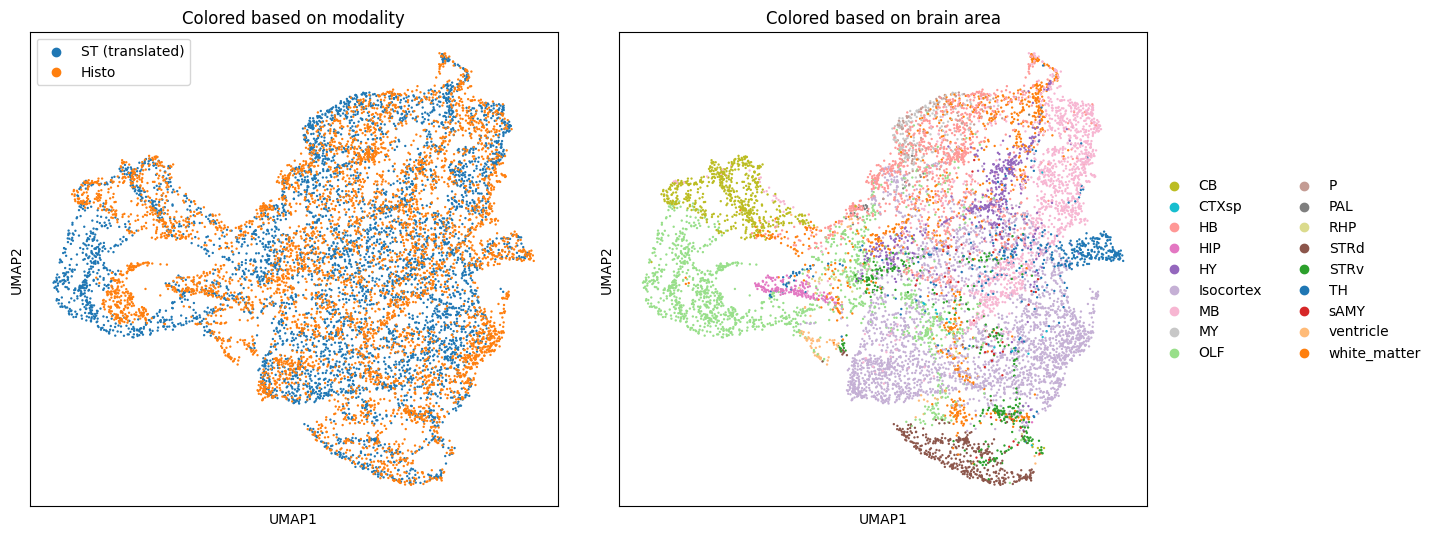

In [18]:
adata.obsm["X_translated_2"] = np.concatenate(
    (translated_fused, ad_histo.obsm["uni_embedding"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_2")
sc.tl.umap(adata)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["brain_area"], ax=ax2, show=False, palette=color_map)
ax2.set_title("Colored based on brain area")
plt.tight_layout(pad=3.0)
plt.show()

==> No improvement in FOSCTTM, even though the brain_area was given as input. The UMAP clusters better between brain_areas, but also starts to distinguish between modalities

## Analyzing cell type transitions
The cell type transition matrix provides a mapping of cell types from one modality to another and can be used to examine the correspondence between cell types across different datasets. The resulting matrix illustrates which cell types are mapped where thereby enabling further downstream analyses. We order the annotations explicitly by providing a dictionary for source_groups and target_groups

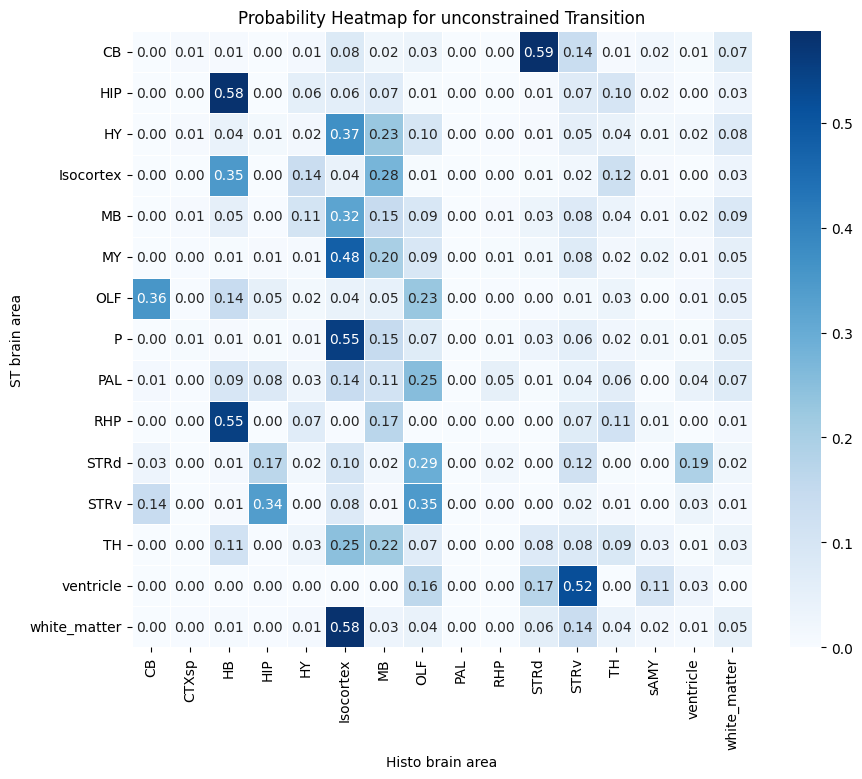

In [64]:
source_order = ad_st.obs["brain_area"].cat.categories
target_order = ad_histo.obs["brain_area"].cat.categories


cell_transition = tp.cell_transition(
    source="src",
    target="tgt",
    source_groups={"brain_area": source_order},
    target_groups={"brain_area": target_order},
    forward=True
)

plt.figure(figsize=(10, 8))
sns.heatmap(cell_transition, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Add labels
plt.ylabel("ST brain area")
plt.xlabel("Histo brain area")
plt.title("Probability Heatmap for unconstrained Transition")

# Show the plot
plt.show()

==> The function tries to access the wrong keys 

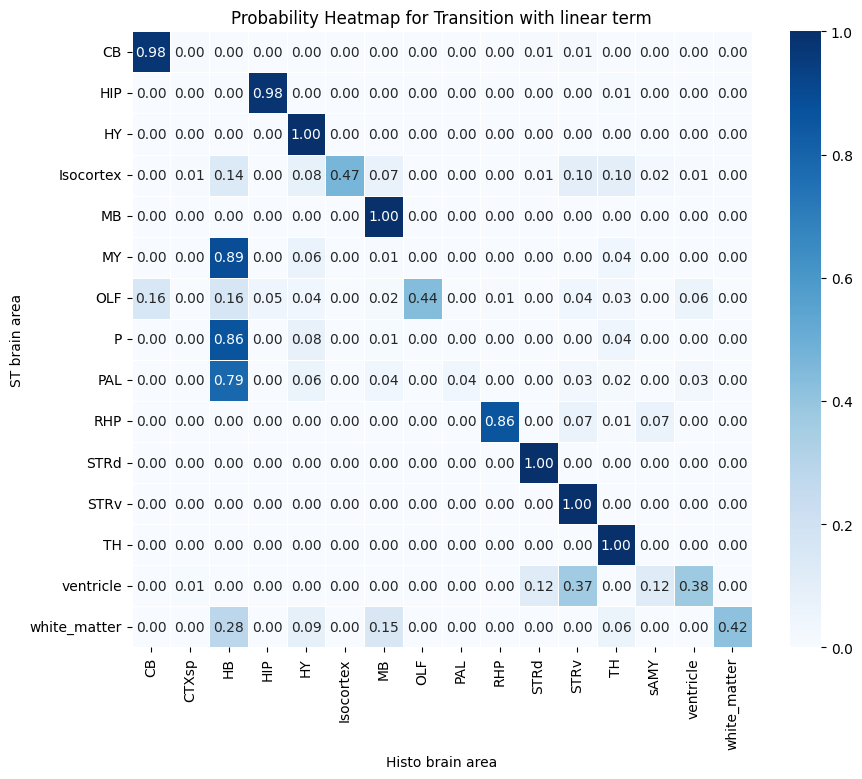

In [22]:
source_order = ad_st.obs["brain_area"].cat.categories
target_order = ad_histo.obs["brain_area"].cat.categories


cell_transition = ftp.cell_transition(
    source="src",
    target="tgt",
    source_groups={"brain_area": source_order},
    target_groups={"brain_area": target_order},
    forward=True
)

plt.figure(figsize=(10, 8))
sns.heatmap(cell_transition, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Add labels
plt.ylabel("ST brain area")
plt.xlabel("Histo brain area")
plt.title("Probability Heatmap for Transition with linear term")

# Show the plot
plt.show()

In [ ]:
cell_transition

### Conclusion
The specifying of brain areas as linear terms causes the transitions to happen mostly between equivalent terms. What does also happen is that two similar but not the same string regions (E.g the Pons <-> Hindbrain or Medulla <-> Hindbrain) can still be recognized as similar, even though their distance in the one-hot encoding that makes up the linear term of the GW is 0. So providing general areas might help to also find more fine grained regions. 

On the other hand, unconstrained GW also shows strong preferences for brain areas in the transitions (up to 60%), of which some make biological sense, while others seem less connected. From ChatGPT:

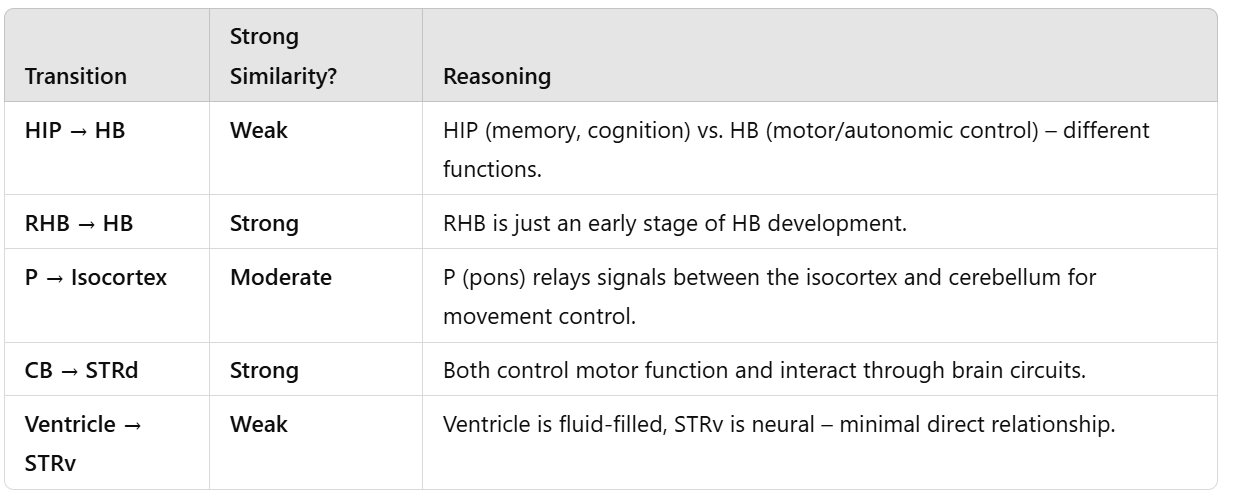

## Use our coordinate information as evaluation method
Since we do have a ground truth for this data, we can evaluate the goodness of the mapping using the ccf coordinates. Let's look at R2 and MSE

This distance infers the coordinates from our source modality using the translation and the fact that we have coordinates for the histology. 
If Y is the coordinate matrix from histology and we have k NN for each sample in the translated embedding, then
$ \text{IDWE} = \frac{\sum_{i=1}^{N} \sum_{j=1}^{k} w_{ij} \cdot (x_i - x_j)^2}{\sum_{i=1}^{N} \sum_{j=1}^{k} w_{ij} }$

And we normalize this by taking the random distance and use 1- to have a score ranging from -inf to 1:
$\text{coord metric} = 1 - \frac{\text{IDWE}}{\sum_{i=1}^{N} (x_i - x_{perm(i)})^2}$

In [1]:
def translation_metric(
    translation, source_features, target_features, target_ad, k = 1, emb_key = "uni_embedding", rank = True
):
    # calculate the k nearest neighbors on the translation
    target_embedding = target_ad.obsm[emb_key]
    source_features = np.array(source_features)
    target_features = np.array(target_features)
    N = source_features.shape[0]
    M = target_features.shape[0]
    
    if k == "all" or k == M:
        # Use cdist for comprehensive but slow neighbor calculation
        k = M
        distance_matrix = cdist(translation, target_embedding, metric='euclidean')

        # Get indices of nearest neighbors sorted by distance
        indices = np.argsort(distance_matrix, axis=1)
        distances = np.sort(distance_matrix, axis=1)
    else:
        # Use knn for faster computation
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(target_embedding)
    
        # Find top-k neighbors in target for each src sample
        distances, indices = nbrs.kneighbors(translation)

    # Calculate the MSE weighted by distance/rank of distance
    if rank:
        # Do not use aczual distances, just weight by rank
        distances = np.tile(np.arange(1, k + 1), (N, 1))
        # Add pseudocount to distances to avoid zero division, and turn into weights by taking inverse
        distances = 1/distances 
    else:
        distances = 1/(distances + 1e-8)

    big_translation = np.repeat(source_features[:, np.newaxis, :], k, axis=1)  # Make array to calculate error
    big_nbrs = target_features[indices]

    idwe = np.sum(np.sum(np.square(big_translation - big_nbrs), axis = 2) * distances, axis = 1)
    idwe = idwe / np.sum(distances, axis = 1)  # Normalize by weights

    # Compare to random by dividing by random distances
    rng = np.random.default_rng()
    perm = rng.choice(M, size = (N, k), replace = True)
    random_nbrs = target_features[perm]
    random_idwe = np.sum(np.sum(np.square(big_translation - random_nbrs), axis = 2) * distances, axis = 1)
    random_idwe = random_idwe / np.sum(distances, axis = 1)  # Normalize by weights

    idwe = 1 - np.mean(idwe) / np.mean(random_idwe)
    
    return float(np.mean(idwe))

In [75]:
# Performance of quadratic GW
idwe = coord_metric(
    translated, 
    ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]], 
    ad_histo, k="all", rank = True
)
idwe

np.float64(-0.012930765452110027)

In [84]:
# Perfect performance
idwe = coord_metric(
    ad_histo.obsm["uni_embedding"], 
    ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]], 
    ad_histo, k=1, rank = True
)
idwe

1.0

In [89]:
# Random performance
idwe = coord_metric(
    ad_histo.obsm["uni_embedding"], 
    ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].sample(frac=1, random_state = 42), 
    ad_histo, k=1, rank = True
)
idwe

0.1163938297986806
27.433136280874425


0.9957571810744866

In [76]:
# Performance of quadratic GW + linear info
idwe = coord_metric(
    translated_fused, 
    ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]], 
    ad_histo, k="all", rank = False
)
idwe

np.float64(0.0354459239764533)